In [1]:
import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit, hessian, lax
from jax.scipy.stats import norm, multivariate_normal

import itertools
from functools import partial
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from scipy.linalg import eigh
from scipy.interpolate import griddata
     
import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value

/tmp/ipykernel_1228104/682568134.py:8: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config
/global/homes/r/rgrumitt/.conda/envs/jax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def distance_matrix(x, y):
    return jnp.sqrt(jnp.sum(jnp.abs(x[:, jnp.newaxis, :] - y[jnp.newaxis, :, :]) ** 2, axis=-1))


# Use double precision to generate data (due to GP sampling)
def RBF(x1, x2, params):
    output_scale, lengthscales = params
    diffs = jnp.expand_dims(x1 / lengthscales, 1) - \
            jnp.expand_dims(x2 / lengthscales, 0)
    r2 = jnp.sum(diffs**2, axis=2)
    return output_scale * jnp.exp(-0.5 * r2)


def kernel(X, Z, var, length):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    return k


class SquaredExponential:
    def __init__(self, coords, mkl, lamb):
        """
        This class sets up a random process
        on a grid and generates
        a realisation of the process, given
        parameters or a random vector.
        """

        # Internalise the grid and set number of vertices.
        self.coords = coords
        self.n_points = self.coords.shape[0]
        self.eigenvalues = None
        self.eigenvectors = None
        self.parameters = None
        self.random_field = None

        # Set some random field parameters.
        self.mkl = mkl
        self.lamb = lamb

        self.assemble_covariance_matrix()

    def assemble_covariance_matrix(self):
        """
        Create a snazzy distance-matrix for rapid
        computation of the covariance matrix.
        """
        #dist = distance_matrix(self.coords, self.coords)
        diffs = jnp.expand_dims(self.coords / self.lamb, 1) - \
                jnp.expand_dims(self.coords / self.lamb, 0)
        r2 = jnp.sum(diffs**2, axis=2)
        self.cov = jnp.exp(-0.5 * r2)

    def plot_covariance_matrix(self):
        """
        Plot the covariance matrix.
        """
        plt.figure(figsize=(10, 8))
        plt.imshow(self.cov, cmap="binary")
        plt.colorbar()
        plt.show()

    def compute_eigenpairs(self):
        """
        Find eigenvalues and eigenvectors using Arnoldi iteration.
        """
        eigvals, eigvecs = eigh(self.cov, eigvals=(self.n_points - self.mkl, self.n_points - 1))

        order = jnp.flip(jnp.argsort(eigvals))
        self.eigenvalues = jnp.asarray(eigvals[order])
        self.eigenvectors = jnp.asarray(eigvecs[:, order])

    def generate(self, parameters=None, key=None):
        """
        Generate a random field, see
        Scarth, C., Adhikari, S., Cabral, P. H.,
        Silva, G. H. C., & Prado, A. P. do. (2019).
        Random field simulation over curved surfaces:
        Applications to computational structural mechanics.
        Computer Methods in Applied Mechanics and Engineering,
        345, 283–301. https://doi.org/10.1016/j.cma.2018.10.026
        """

        if parameters is None:
            if key is None:
                key = random.PRNGKey(0)
            self.parameters = random.normal(key, shape=(self.mkl,))
        else:
            self.parameters = jnp.array(parameters).flatten()

        self.random_field = jnp.linalg.multi_dot(
            (self.eigenvectors, jnp.sqrt(jnp.diag(self.eigenvalues)), self.parameters)
        )

    def plot(self, lognormal=True):
        """
        Plot the random field.
        """

        if lognormal:
            random_field = self.random_field
            contour_levels = jnp.linspace(min(random_field), max(random_field), 20)
        else:
            random_field = jnp.exp(self.random_field)
            contour_levels = jnp.linspace(min(random_field), max(random_field), 20)

        plt.figure(figsize=(12, 10))
        plt.tricontourf(
            self.coords[:, 0],
            self.coords[:, 1],
            random_field,
            levels=contour_levels,
            cmap="plasma",
        )
        plt.colorbar()
        plt.show()


class Matern52(SquaredExponential):
    def assemble_covariance_matrix(self):
        """
        This class inherits from RandomProcess and creates a Matern 5/2 covariance matrix.
        """

        # Compute scaled distances.
        dist = jnp.sqrt(5.0) * distance_matrix(self.coords, self.coords) / self.lamb

        # Set up Matern 5/2 covariance matrix.
        self.cov = (1 + dist + dist**2 / 3) * jnp.exp(-dist)

In [3]:
# A diffusion-reaction numerical solver
def solve_ARD(s0, 
              u, 
              Nx, 
              Nt,
              Diff=1.,
              gamma=1.,
              xmin=0, 
              xmax=1, 
              tmin=0, 
              tmax=1):
    """Solve 1D
    s_t = (k(x) s_x)_x - v(x) s_x + g(s) + u(x).
    """
    
    k = lambda x: Diff * jnp.ones_like(x)
    v = lambda x: jnp.zeros_like(x)
    #g = lambda s: gamma * s * (1 - s)
    #dg = lambda s: gamma - 2 * gamma * s
    g = lambda s: gamma * s ** 2
    dg = lambda s: 2 * gamma * s

    # Create grid
    x = jnp.linspace(xmin, xmax, Nx)
    t = jnp.linspace(tmin, tmax, Nt)
    h = x[1] - x[0]
    dt = t[1] - t[0]
    h2 = h ** 2

    # Compute coefficients
    k = k(x)
    v = v(x)

    # Compute finite difference operators
    D1 = jnp.eye(Nx, k=1) - jnp.eye(Nx, k=-1)
    D2 = -2 * jnp.eye(Nx) + jnp.eye(Nx, k=-1) + jnp.eye(Nx, k=1)
    D3 = jnp.eye(Nx - 2)
    M = -jnp.diag(D1 @ k) @ D1 - 4 * jnp.diag(k) @ D2
    m_bond = 8 * h2 / dt * D3 + M[1:-1, 1:-1]
    v_bond = 2 * h * jnp.diag(v[1:-1]) @ D1[1:-1, 1:-1] + 2 * h * jnp.diag(
        v[2:] - v[: Nx - 2]
    )
    mv_bond = m_bond + v_bond
    c = 8 * h2 / dt * D3 - M[1:-1, 1:-1] - v_bond

    # Initialize solution and apply initial condition
    s = jnp.zeros((Nx, Nt))
    s = s.at[:, 0].set(s0)
    # Time-stepping update
    def body_fn(i, s):
        gi = g(s[1:-1, i])
        dgi = dg(s[1:-1, i])
        h2dgi = jnp.diag(4 * h2 * dgi)
        A = mv_bond - h2dgi
        b1 = 8 * h2 * (0.5 * u[1:-1] + 0.5 * u[1:-1] + gi)
        b2 = (c - h2dgi) @ s[1:-1, i].T
        s = s.at[1:-1, i + 1].set(jnp.linalg.solve(A, b1 + b2))
        return s
    # Run loop
    SS = lax.fori_loop(0, Nt-1, body_fn, s)

    return SS

In [4]:
class ARD:
    """
    Implements a solver for the advection-reaction-diffusion equations.
    """

    def __init__(self, s0_function, u_function, diff, gamma, n_x, n_t, n_x_data, n_t_data):

        # Set the function describing the initial signal.
        self.s0_function = s0_function
        
        # Set the function describing the source term.
        self.u_function = u_function

        # Set the reaction-diffusion coefficients
        self.diff = diff
        self.gamma = gamma

        # Set the number of data points along one dimension
        self.n_t = n_t
        self.n_x = n_x
        self.n_t_data = n_t_data
        self.n_x_data = n_x_data

        # Set the quadrature points.
        self.x = jnp.linspace(0, 1, self.n_x)
        self.t = jnp.linspace(0, 1, self.n_t)

        # Set the measurement points.
        self.xidx = jnp.arange(int(self.n_x / self.n_x_data / 2), self.n_x, step=int(self.n_x / self.n_x_data))
        self.tidx = jnp.arange(int(self.n_t / self.n_t_data / 2), self.n_t, step=int(self.n_t / self.n_t_data))
        self.mesh_x, self.mesh_t = jnp.meshgrid(self.x[self.xidx], self.t[self.tidx])
        self.mesh_xidx, self.mesh_tidx = jnp.meshgrid(self.xidx, self.tidx)

        self.s0 = self.s0_function(self.x)
        self.u = self.u_function(self.x)
        self.ss = solve_ARD(self.s0, 
                            self.u, 
                            self.n_x, 
                            self.n_t, 
                            self.diff, 
                            self.gamma, 
                            0,
                            1,
                            0,
                            1)
        
        self.gg = self.ss[self.mesh_xidx, self.mesh_tidx].ravel()

    def plot_model(self):

        # Plot the density and the signal.
        fig, axes = plt.subplots(1, 1, figsize=(16, 6))
        axes.set_title(r"$s(x, t)$")
        f = axes.imshow(
            self.ss,
            extent=(0, 1, 0, 1),
            origin="lower",
            cmap="icefire"
        )
        axes.scatter(self.mesh_t, self.mesh_x, color='w')
        axes.set_xlabel(r'$t$')
        axes.set_ylabel(r'$x$')
        fig.colorbar(f, ax=axes)
        plt.show()

In [5]:
# --- Modelling utility functions --- #
def spectral_density(w, alpha, length):
    c = alpha * jnp.sqrt(2 * jnp.pi) * length
    e = jnp.exp(-0.5 * (length**2) * (w**2))
    return c * e


def diag_spectral_density(alpha, length, L, M):
    sqrt_eigenvalues = jnp.arange(1, 1 + M) * jnp.pi / 2 / L
    return spectral_density(sqrt_eigenvalues, alpha, length)


def eigenfunctions(x, L, M):
    """
    The first `M` eigenfunctions of the laplacian operator in `[-L, L]`
    evaluated at `x`. These are used for the approximation of the
    squared exponential kernel.
    """
    m1 = (jnp.pi / (2 * L)) * jnp.tile(L + x[:, None], M)
    m2 = jnp.diag(jnp.linspace(1, M, num=M))
    num = jnp.sin(m1 @ m2)
    den = jnp.sqrt(L)
    return num / den


# --- Approximate Gaussian processes --- #
def approx_se_ncp(x, alpha, length, beta, L):
    """
    Hilbert space approximation for the squared
    exponential kernel in the non-centered parametrisation.
    """
    phi = eigenfunctions(x, L, beta.shape[0])
    spd = jnp.sqrt(diag_spectral_density(alpha, length, L, beta.shape[0]))
    f = phi @ (spd * beta)
    return f


class ARD_Forward(ARD):
    """
    ADR forward defines the forward model for the advection, reaction, diffusion system.
    """

    def __init__(self, diff, gamma, n_x, n_t, n_x_data, n_t_data):

        # Set the reaction-diffusion coefficients
        self.diff = diff
        self.gamma = gamma

        # Set the number of data points along one dimension
        self.n_t = n_t
        self.n_x = n_x
        self.n_t_data = n_t_data
        self.n_x_data = n_x_data

        # Set the quadrature points.
        self.x = jnp.linspace(0, 1, self.n_x)
        self.t = jnp.linspace(0, 1, self.n_t)

        # Set the measurement points.
        self.xidx = jnp.arange(int(self.n_x / self.n_x_data / 2), self.n_x, step=int(self.n_x / self.n_x_data))
        self.tidx = jnp.arange(int(self.n_t / self.n_t_data / 2), self.n_t, step=int(self.n_t / self.n_t_data))
        self.mesh_x, self.mesh_t = jnp.meshgrid(self.x[self.xidx], self.t[self.tidx])
        self.mesh_xidx, self.mesh_tidx = jnp.meshgrid(self.xidx, self.tidx)

    def set_random_process(self, random_process, lamb, mkl):

        # Set the number of KL modes.
        self.mkl = mkl

        # Initialise a random process on the quadrature points.
        # and compute the eigenpairs of the covariance matrix,
        self.random_process = random_process(self.x, self.mkl, lamb)
        self.random_process.compute_eigenpairs()

    def solve(self, mean, alpha, theta, lamb=0.3):

        # Internalise the Random Field parameters
        self.parameters = theta

        # Create a realisation of the random process, given the parameters.
        #self.random_process.generate(self.parameters)

        # Set the density.
        #self.u = mean + stdev * self.random_process.random_field
        hgp = approx_se_ncp(self.x - 0.5, alpha, lamb, self.parameters, 2.)
        self.u = mean + hgp
        
        self.ss = solve_ARD(jnp.zeros(self.n_x), 
                            self.u, 
                            self.n_x, 
                            self.n_t, 
                            self.diff, 
                            self.gamma, 
                            0,
                            1,
                            0,
                            1) 
        
        self.gg = self.ss[self.mesh_xidx, self.mesh_tidx].ravel()

    def get_data(self):

        # Get the data vector.
        return self.gg

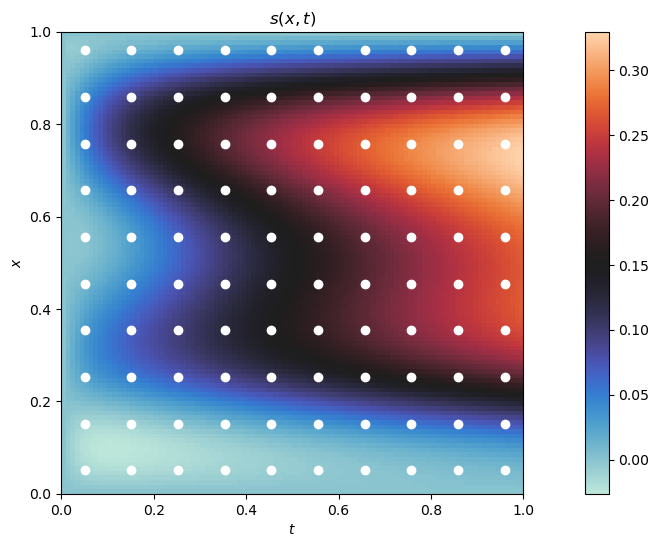

In [6]:
theta = random.normal(random.PRNGKey(2020), shape=(50,))
true_theta = jnp.copy(theta)

diff = 0.1
gamma = 0.1

s0_function = lambda x: jnp.zeros(len(x))
def u0_function(x, theta=theta, alpha=1.0, lamb=0.1):
    hgp = approx_se_ncp(x - 0.5, alpha, lamb, theta, 2.)
    return hgp

ard = ARD(s0_function, u0_function, diff, gamma, 100, 100, 10, 10)
ard.plot_model()

noise_level = 0.01
data = ard.gg + random.normal(random.PRNGKey(1943), shape=ard.gg.shape) * noise_level

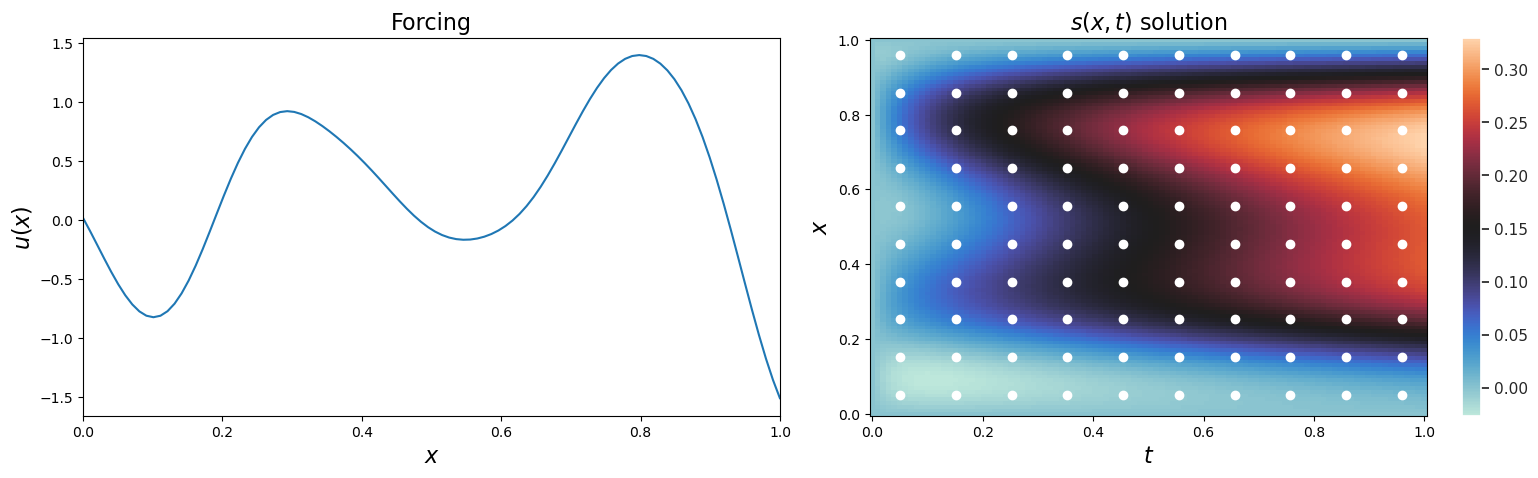

In [7]:
# Generate an uniform mesh
x = jnp.linspace(0, 1, 100)
t = jnp.linspace(0, 1, 100)
XX, TT = jnp.meshgrid(x, t)


fontsize = 16
fig, axes = plt.subplots(1, 2, figsize=(8*2, 8 / 1.61803398875))

sns.set_theme()

g = axes[0].plot(x, u0_function(jnp.linspace(0, 1, 100)))
axes[0].set_xlabel(r'$x$', fontsize=fontsize)
axes[0].set_ylabel(r'$u(x)$', fontsize=fontsize)
axes[0].set_title('Forcing', fontsize=fontsize)
plt.tight_layout()
axes[0].set_xlim(0, 1)

im = axes[1].pcolor(XX, TT, ard.ss, cmap='icefire')
axes[1].set_xlabel(r'$t$', fontsize=fontsize)
axes[1].set_ylabel(r'$x$', fontsize=fontsize)
axes[1].set_title(r'$s(x,t)$ solution', fontsize=fontsize)
axes[1].scatter(ard.mesh_t, ard.mesh_x, color='w')
plt.tight_layout()
fig.colorbar(im, ax=axes[1])

# Numpyro Model

In [12]:
#ard_solver = ARD_Forward(diff, gamma, 100, 100, 10, 10)

def reaction_diffusion_model(data, noise_level, x=x, order=50, Nx=100, Nt=100):
    
    utheta = numpyro.sample('utheta', dist.Normal(jnp.zeros(order), jnp.ones(order)))
    ualpha = numpyro.sample('ualpha', dist.HalfNormal(1.0))
    umean = numpyro.sample('umean', dist.Normal(0.0, 0.1))
    ulen = numpyro.sample('ulen', dist.InverseGamma(concentration=4, rate=0.3))
    
    ard_solver = ARD_Forward(0.1, 0.1, 100, 100, 10, 10)
    ard_solver.solve(umean, ualpha, utheta, lamb=ulen)
    sim = ard_solver.get_data()
    llk = numpyro.sample('llk', dist.Normal(sim, noise_level), obs=data)

In [13]:
def run_inference(model, num_warmup, num_samples, num_chains, rng_key, data, noise_level):
    
    init_strategy = init_to_value(
                        values={"umean": 0.,
                                "utheta": true_theta,
                                "ualpha": 1.0,
                                "ulen": 0.1})
    
    kernel = NUTS(model, max_tree_depth=7, target_accept_prob=0.95, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        progress_bar=True,
    )
    mcmc.run(rng_key, data, noise_level)
    mcmc.print_summary()
    return mcmc, mcmc.get_samples()

In [ ]:
mcmc, samples = run_inference(reaction_diffusion_model, 5000, 5000, 1, random.PRNGKey(0), data, noise_level)